In [ ]:
!pip install --upgrade spacy

In [ ]:
!python -m spacy download ru_core_news_lg

In [5]:
import spacy
from spacy.lang.ru.examples import sentences
nlp = spacy.load('ru_core_news_lg')
#для скачивания и добавления файлов
from google.colab import files
#пандас для работы с dataframe
import pandas as pd
#sqlite3 для работы с базами данных 
import sqlite3

Функции для парсинга текста и наполнения словарей

In [4]:
# Таблица 1: Действующие лица
def make_dict_persons(contents):
  persons = dict()
  length = len(contents)
  p = 0

  # ФИО персонажей
  for i in range(p, length):
    if 'ДЕЙСТВУЮЩИЕ ЛИЦА' in contents[i]:
      i += 1
      while 'Гости и гостьи' not in contents[i]:
        content = contents[i].split('\n')[0]
        lexems = content.split(', ')
        l = len(lexems) - 1
        if l > 0:
          name = []
          for j in range(l):
            name.append(lexems[j])
          persons[', '.join(name)] = [lexems[l].split('.')[0].capitalize()]
        i += 1
      p = i
      break

 # Характеристики
  for i in range(p, length):
    if 'Замечания для господ актеров' in contents[i]:
      i += 1
      while 'Прочие роли' not in contents[i]:
        content = contents[i].split('\n')[0]
        keyname = content.split(', ')[0].lower()
        keys = persons.keys()
        for k in keys:
          if keyname in k.lower() or keyname in persons[k][0].lower():
            persons[k].append(content)
            break
        i += 1
      p = i
      break

  # Если характеристики не найдены, добавляем ''
  keys = persons.keys()
  for k in keys:
    if len(persons[k]) == 1:
      persons[k].append('')

  return persons


# Таблица 2: Действия
def make_dict_acts(contents):
  acts = dict()
  p = 0

  content_acts = ''.join(contents).split('ДЕЙСТВИЕ')
  content_acts.remove(content_acts[0])
  count_acts = len(content_acts)
  
  for i in range(3):
    parts = content_acts[i].split('ЯВЛЕНИЕ')
    parts.remove(parts[0])

    count_parts = len(parts)
    for j in range(count_parts):
      strings = parts[j].split('\n')
      strings.remove(strings[0])

      count_strings = len(strings)
      for m in range(count_strings):
        lexema = strings[m].split('. ')[0].split()

        if len(lexema) < 3:

          lexema_ = ' '.join(lexema).split(' (')[0]

          if lexema_ in acts.keys():
            acts[lexema_].add((i + 1, j + 1))
          else:
            lexema__ = nlp(lexema_)
            not_name = True
            for token in lexema__:
              if token.pos_ == 'VERB' or token.pos_ == 'ADV' or token.pos_ =='PRON' or token.pos_ =='DET':
                 # print('Предатель найден :', lexema_)
                  not_name = False
                  break
              
              if token.dep_ == 'nmod' or token.dep_ == 'obj':
                 # print('Предатель найден :', lexema_)
                  not_name = False
                  break

            if lexema_ != '' and not_name == True:
              acts[lexema_] = set()
      
  return acts


  # Таблица 3: реплики
def make_dict_replics(contents):
  replics = dict()
  p = 0

  content_acts = ''.join(contents).split('ДЕЙСТВИЕ')
  content_acts.remove(content_acts[0])
  count_acts = len(content_acts)
  
  for i in range(count_acts):
    parts = content_acts[i].split('ЯВЛЕНИЕ')
    parts.remove(parts[0])

    count_parts = len(parts)
    for j in range(count_parts):
      strings = parts[j].split('\n')
      strings.remove(strings[0])

      count_strings = len(strings)
      for m in range(count_strings):
        lexema = strings[m].split('. ')[0].split()

        if len(lexema) < 3:
          lexema_ = ' '.join(lexema)
          lexems = strings[m].split('. ')[1:len(strings[m])]
          if len(lexems) == 0:
            continue
          if '(' not in lexema_ and 'голос' not in lexema_ and 'Голос' not in lexema_ and '.' not in lexema_ :
            replics[p] = [lexema_, lexems[0], i+1, j+1]
            p += 1
      
  return replics

In [6]:
# функции для работы с sql запросами
def tableCreation(c, conn):
#table creation begin    
#Create necessary tables with sql querries
    c.execute('CREATE TABLE IF NOT EXISTS Actors (actorID int NOT NULL PRIMARY KEY, name nvchar(100), profession nvchar(100), description nvarchar(5000))')
    c.execute('CREATE TABLE IF NOT EXISTS Speech (speechID int NOT NULL PRIMARY KEY, name nvchar(100), actNum int, partNum int, speechText text)')
    c.execute('CREATE TABLE IF NOT EXISTS Acts (actsID int NOT NULL PRIMARY KEY, name nvchar(100), actNum int, partNum int)')
    conn.commit()
#table creation end

def dropAllTheTables(c, conn):
#clear all the tables
    try:
        c.execute('''DROP TABLE Actors''')
        c.execute('''DROP TABLE Speech''')
        c.execute('''DROP TABLE Acts''')
        conn.commit()
    except:
        return 0
#end of dropAllTheTables

def showTable(c, tableName):
#show table begin
#Print all the rows in 'tableName' table
    sqlString = 'SELECT * FROM ' + tableName
    c.execute(sqlString)
    for row in c.fetchall():
        print (row)
#show table end

def getLastID(c, rowName, tableName):
#get Last ID begin
#Return maximum ID in 'tableName' table for better iteration
    sqlString = 'SELECT ' + rowName + ' FROM ' + tableName
    c.execute(sqlString)
    max = -1
    for row in c.fetchall():
        max = row
    if (max == -1):
        #print(max)
        return max
    else:
        max = int(max[0])
        #print(max)
        return max
#get Last ID end

def fillUpActorsTableSTR(c, conn, name, profession, description):
#fill Up Actors Table begin
    iter = getLastID(c, 'actorID', 'Actors')
    ins = {'actorID': iter + 1,'name': name, 'profession': profession, 'description': description}
    df = pd.DataFrame([ins], columns= ['actorID', 'name', 'profession', 'description'])
    df.to_sql('Actors', conn, if_exists='append',index=False)
#fill Up Actors Table end


def fillUpSpeechTableSTR(c, conn, name, actNum, partNum, speechText):
#fill Up Speech Table begin
    iter = getLastID(c, 'speechID', 'Speech')
    ins = {'speechID': iter + 1, 'name': name, 'actNum': actNum, 'partNum': partNum, 'speechText': speechText}
    df = pd.DataFrame([ins], columns= ['speechID','name', 'actNum', 'partNum', 'speechText'])
    df.to_sql('Speech', conn, if_exists='append', index=False)
#fill Up Speech Table end


def fillUpActsTableSTR(c, conn, name, actNum, partNum):
#fill Up Acts Table begin
    iter = getLastID(c, 'actsID', 'Acts')
    ins = {'actsID': iter + 1, 'name': name, 'actNum': actNum, 'partNum': partNum}
    df = pd.DataFrame([ins], columns= ['actsID','name', 'actNum', 'partNum'])
    #print(df)
    df.to_sql('Acts', conn, if_exists='append', index=False)
#fill Up Acts Table end


In [ ]:
#uploading
uploaded = files.upload()
 
for fn in uploaded.keys():

  f = open(fn, 'r', encoding='utf-8')
  contents = f.readlines()

length = len(contents)
for content in contents:
  if content == '\n':
    contents.remove(content)

dic1 = make_dict_persons(contents)
dic2 = make_dict_acts(contents)
dic3 = make_dict_replics(contents)

In [9]:
conn = sqlite3.connect('database.db')
c = conn.cursor()
dropAllTheTables(c, conn)
tableCreation(c, conn)

dicPers = dic1
keysPers = dicPers.keys()
dicAct = dic2
keysAct = dicAct.keys()
dicSpch = dic3
keysSp = dicSpch.keys()

# добавление информации в таблицу с главными героями
for k in keysPers: 
    #fillUpActorsTableSTR(c, conn, name, profession, description)
    fillUpActorsTableSTR(c, conn, k, dicPers[k][0], dicPers[k][1])

for k in keysSp:
    #fillUpSpeechTableSTR(c, conn, name, actNum, partNum, speechText)
    fillUpSpeechTableSTR(c, conn, dicSpch[k][0], dicSpch[k][2], dicSpch[k][3], dicSpch[k][1])

for k in keysAct:
  for dt in dic2[k]:
    #fillUpActsTableSTR(c, conn, name, actNum, partNum):
    fillUpActsTableSTR(c, conn, k, dt[0], dt[1])
    #print(k, dt[0], 'and', dt[1])

#Создание всех дата фреймов для таблиц
dfPers = pd.read_sql('SELECT * FROM actors', conn)
dfAct = pd.read_sql('SELECT * FROM acts', conn)
dfSpch = pd.read_sql('SELECT * FROM speech', conn)


In [24]:
# Таблица 1 - герои
dfPers

,actorID,name,profession,description
0,0,Антон Антонович Сквозник-Дмухановский,Городничий,"Городничий, уже постаревший на службе и очень ..."
1,1,Анна Андреевна,Жена его,"Анна Андреевна, жена его, провинциальная кокет..."
2,2,Марья Антоновна,Дочь его,
3,3,Лука Лукич Хлопов,Смотритель училищ,
4,4,Аммос Федорович Ляпкин-Тяпкин,Судья,"Ляпкин-Тяпкин, судья, человек, прочитавший пят..."
5,5,Артемий Филиппович Земляника,Попечитель богоугодных заведений,"Земляника, попечитель богоугодных заведений, о..."
6,6,Иван Кузьмич Шпекин,Почтмейстер,"Почтмейстер, простодушный до наивности человек."
7,7,"Петр Иванович Добчинский, Петр Иванович Бобчин...",Городские помещики,
8,8,Иван Александрович Хлестаков,Чиновник из петербурга,"Хлестаков, молодой человек лет двадцати трех, ..."
9,9,Осип,Слуга его,"Осип, слуга, таков, как обыкновенно бывают слу..."


In [22]:
# Таблица 2 - в каких явлениях и актах присутсвует герой
dfAct

,actsID,name,actNum,partNum
0,0,Городничий,1,2
1,1,Городничий,1,3
2,2,Городничий,2,9
3,3,Городничий,2,8
4,4,Городничий,3,10
...,...,...,...,...
61,61,Осип,3,4
62,62,Слуга,2,6
63,63,Слуга,2,4
64,64,Слуга,2,9


In [23]:
# Таблица 3 - реплики героев (кем сказаны, в каком действии и в каком явлении)
dfSpch

,speechID,name,actNum,partNum,speechText
0,0,Городничий,1,1,"Я пригласил вас, господа, с тем чтобы сообщить..."
1,1,Аммос Федорович,1,1,Как ревизор?
2,2,Артемий Филиппович,1,1,Как ревизор?
3,3,Городничий,1,1,Ревизор из Петербург инкогнито
4,4,Аммос Федорович,1,1,Вот те на!
...,...,...,...,...,...
734,734,Артемий Филиппович,5,7,Сморчки короткобрюхие!
735,735,Бобчинский,5,7,"Ей-богу, это не я, это Петр Иванович."
736,736,Добчинский,5,7,"Э, нет, Петр Иванович, вы ведь первые того…"
737,737,Бобчинский,5,7,А вот и нет; первые-то были вы.


In [10]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
#actsID name actNum partNum
#speechID name actNum partNum speechText
#actorID name profession description

In [11]:
# сортировка главных героев по имени - модификация 1
dfPers.sort_values(by="name")

,actorID,name,profession,description
14,14,Абдулин,Купец,
4,4,Аммос Федорович Ляпкин-Тяпкин,Судья,"Ляпкин-Тяпкин, судья, человек, прочитавший пят..."
1,1,Анна Андреевна,Жена его,"Анна Андреевна, жена его, провинциальная кокет..."
0,0,Антон Антонович Сквозник-Дмухановский,Городничий,"Городничий, уже постаревший на службе и очень ..."
5,5,Артемий Филиппович Земляника,Попечитель богоугодных заведений,"Земляника, попечитель богоугодных заведений, о..."
8,8,Иван Александрович Хлестаков,Чиновник из петербурга,"Хлестаков, молодой человек лет двадцати трех, ..."
6,6,Иван Кузьмич Шпекин,Почтмейстер,"Почтмейстер, простодушный до наивности человек."
3,3,Лука Лукич Хлопов,Смотритель училищ,
2,2,Марья Антоновна,Дочь его,
16,16,Мишка,Слуга городничего,


In [12]:
# количество реплик у каждого героя - модификация 2
a = dfSpch["name"].value_counts()

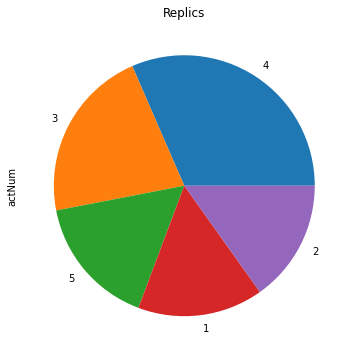

In [13]:
# количество реплик по действиям - модификация 3, график 1
plt.figure(figsize=(6, 6))
dfSpch["actNum"].value_counts().plot(kind='pie');
plt.title('Replics');

In [14]:
# удаление описания внешности героя - модификация 4
dfPers.drop(['description'], axis=1)

,actorID,name,profession
0,0,Антон Антонович Сквозник-Дмухановский,Городничий
1,1,Анна Андреевна,Жена его
2,2,Марья Антоновна,Дочь его
3,3,Лука Лукич Хлопов,Смотритель училищ
4,4,Аммос Федорович Ляпкин-Тяпкин,Судья
5,5,Артемий Филиппович Земляника,Попечитель богоугодных заведений
6,6,Иван Кузьмич Шпекин,Почтмейстер
7,7,"Петр Иванович Добчинский, Петр Иванович Бобчин...",Городские помещики
8,8,Иван Александрович Хлестаков,Чиновник из петербурга
9,9,Осип,Слуга его


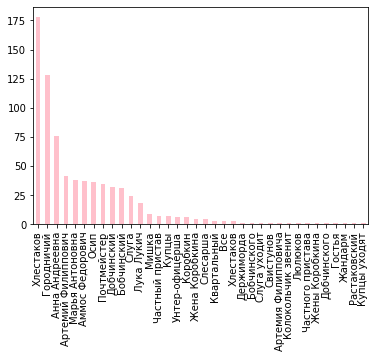

In [15]:
# график 2
dfSpch["name"].value_counts().plot.bar(color='pink');

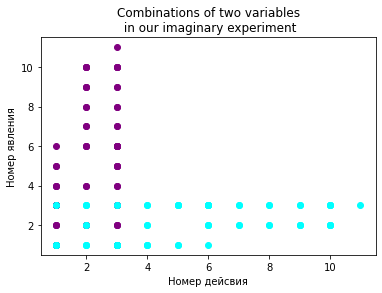

In [28]:
# график 3 - распределение появления персонажей
X = dfAct["actNum"].to_list()
Y = dfAct["partNum"].to_list()

plt.scatter(X, Y, color='purple', label='group 1') # changing the color, adding labels
plt.scatter(Y, X, color='cyan', label='group 2') # adding a second group of data
plt.title('Распределение появления персонажей') # the title
plt.ylabel('Номер явления')
plt.xlabel('Номер дейсвия')
plt.show()

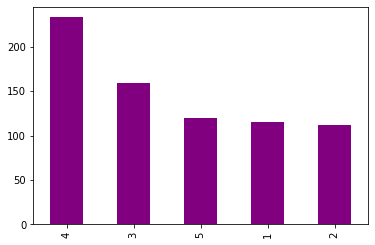

In [ ]:
# график 4 - количество реплик по действиям
dfSpch["actNum"].value_counts().plot.bar(color='purple');

Загрузка базы данных на компьютер

In [ ]:
#загрузка готовой базы данных в файл "test_database.db"
files.download("database.db")
files.download("testSQLTableOutput.txt")